# Load and Prepare Posterior Data

This section sets up your scenarios/hypotheses and loads in your H0 measurements.
The jacknife resample is then run to get posterior distributions for each hypothesis. This is currently set up for 16C11.


In [30]:
from chiborg import jk_data, jk_hyp, jk_calc, tm_prior
from chiborg.util import get_mut_info
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import uniform
from more_itertools import powerset
import pandas as pd
import random
import itertools
from scipy.stats import uniform
import seaborn as sns
import pickle
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [31]:
# Load and prepare data
# Change `file_path` to the location of your Excel file
file_path = 'C:/Users/tjhug/OneDrive/Documents/GitHub/H0 measurements.xlsx'
my_data = pd.read_excel(file_path, sheet_name='Independent points', nrows=16)

# Select H_0 measurements and noise columns
hubble_data = my_data.iloc[:, 6].to_numpy()
noise_column = my_data.iloc[:, 12]
noise_width = noise_column.to_numpy()

# Category column to identify CMB, BAO, LDL, and One-step measurements
category_column = my_data.iloc[:, 16].to_numpy()

In [32]:
# Initialise the bias mean and bias covariance
num_scenarios = 8
num_indices = 11
bias_mean = [np.full(num_indices, 0.0) for i in range(num_scenarios)]
bias_cov = [np.zeros((num_indices, num_indices)) for i in range(num_scenarios)]


In [33]:

# Group indices dynamically by measurement category
category_groups = {'CMB': [], 'BAO': [], 'LDL': [], 'Local One Step': [],'Distant One Step': []}
for idx, category in enumerate(category_column):
    if category in category_groups:
        category_groups[category].append(idx)


In [34]:
# Set up scenario configurations for bias and covariance
scenario_configs = {
    1: {'CMB': 0, 'BAO': 0, 'LDL': 0, 'Local One Step': 0, 'Distant One Step':0, 'cov_CMB': 0, 'cov_BAO': 0, 'cov_LDL': 0, 'cov_Local One Step': 0, 'cov_Distant One Step': 0},
    2: {'CMB': 0, 'BAO': 0, 'LDL': 4, 'Local One Step': 0, 'Distant One Step':0, 'cov_CMB': 1, 'cov_BAO': noise_width[category_groups['BAO']], 'cov_LDL': 9, 'cov_Local One Step': noise_width[category_groups['Local One Step']], 'cov_Distant One Step': noise_width[category_groups['Distant One Step']]},
    3: {'CMB': -4, 'BAO': 0, 'LDL': 0, 'Local One Step': 0, 'Distant One Step':0, 'cov_CMB': 9, 'cov_BAO': noise_width[category_groups['BAO']], 'cov_LDL': 1, 'cov_Local One Step': noise_width[category_groups['Local One Step']],'cov_Distant One Step': noise_width[category_groups['Distant One Step']]},
    4: {'CMB': -2.5, 'BAO': 0, 'LDL': 2.5, 'Local One Step': 0, 'Distant One Step':0, 'cov_CMB': 2.25, 'cov_BAO': noise_width[category_groups['BAO']], 'cov_LDL': 2.25, 'cov_Local One Step': noise_width[category_groups['Local One Step']],'cov_Distant One Step': noise_width[category_groups['Distant One Step']]},
    5: {'CMB': -4.5, 'BAO': -3, 'LDL': 0, 'Local One Step': 0, 'Distant One Step':-1.5, 'cov_CMB': 2.25, 'cov_BAO': 2.25, 'cov_LDL': noise_width[category_groups['LDL']], 'cov_Local One Step': noise_width[category_groups['Local One Step']],'cov_Distant One Step': 2.25},
    6: {'CMB': -1.5, 'BAO': -1.5, 'LDL': 0, 'Local One Step': 0, 'Distant One Step':-1.5, 'cov_CMB': 2.25, 'cov_BAO': 2.25, 'cov_LDL': noise_width[category_groups['LDL']], 'cov_Local One Step': noise_width[category_groups['Local One Step']],'cov_Distant One Step': 2.25},
    7: {'CMB': 0, 'BAO': 0, 'LDL': 4, 'Local One Step': 0, 'Distant One Step':0, 'cov_CMB': 1, 'cov_BAO': noise_width[category_groups['BAO']], 'cov_LDL': 2.25, 'cov_Local One Step': noise_width[category_groups['Local One Step']], 'cov_Distant One Step': noise_width[category_groups['Distant One Step']]},
    8: {'CMB': -4, 'BAO': 0, 'LDL': 0, 'Local One Step': 0, 'Distant One Step':0, 'cov_CMB': 2.25, 'cov_BAO': noise_width[category_groups['BAO']], 'cov_LDL': 1, 'cov_Local One Step': noise_width[category_groups['Local One Step']],'cov_Distant One Step': noise_width[category_groups['Distant One Step']]},
}



In [35]:
# Random sampling of indices (default 16C11)
random_indices = random.sample(range(16), 11)

In [ ]:
# Function to apply bias configurations for a given scenario
def apply_bias_configurations(scenario_index, config, groups, random_indices):
    """
    Apply bias configurations for a scenario, accounting for random index re-ordering.

    Parameters
    ----------
    scenario_index : int
        Index of the scenario (1-based).
    config : dict
        Dictionary containing bias and covariance for each measurement category.
    groups : dict
        Dictionary mapping category names to original data indices.
    random_indices : list
        List of randomly sampled indices from the data.

    Returns
    -------
    None
        Updates the global bias_mean and bias_cov lists in place.
    """
    # Convert scenario index from 1-based to 0-based to match list indexing
    scenario_index -= 1

    # Initialise temporary arrays to store bias mean and covariance for this scenario
    # These arrays are aligned with the randomly sampled indices
    temp_bias_mean = np.zeros(len(random_indices))
    temp_bias_cov = np.zeros((len(random_indices), len(random_indices)))

    # Loop over each measurement category
    for group_name, indices in groups.items():
        if group_name in config:
            # Apply the bias mean for this category
            bias_value = config[group_name]
            for original_idx in indices:
                if original_idx in random_indices:
                    # Map the original index to the corresponding position in the random_indices
                    reordered_idx = random_indices.index(original_idx)
                    temp_bias_mean[reordered_idx] = bias_value

            # Retrieve covariance specification for this group
            cov_value = config[f'cov_{group_name}']

            # Identify which indices from this group are sampled
            reordered_group_indices = [(i, random_indices.index(idx))
                                       for i, idx in enumerate(indices) if idx in random_indices]

            # Case: scenarios 1–3 (independent noise structure)
            if scenario_index <= 3 or scenario_index >= 6:
                for i1, row_idx in reordered_group_indices:
                    if np.isscalar(cov_value):
                        temp_bias_cov[row_idx, row_idx] = cov_value
                    else:
                        temp_bias_cov[row_idx, row_idx] = cov_value[i1]

            # Case: scenarios 4–6 (block diagonal with perfect correlation)
            else:
                for i1, row_idx in reordered_group_indices:
                    for i2, col_idx in reordered_group_indices:
                        if np.isscalar(cov_value):
                            var_i = var_j = cov_value
                        else:
                            var_i = cov_value[i1]
                            var_j = cov_value[i2]

                        if row_idx == col_idx:
                            temp_bias_cov[row_idx, col_idx] = var_i
                        else:
                            temp_bias_cov[row_idx, col_idx] = np.sqrt(var_i * var_j)


    # Save the computed bias mean and covariance for this scenario to the global lists
    bias_mean[scenario_index] = temp_bias_mean
    bias_cov[scenario_index] = temp_bias_cov


In [37]:
# Apply bias configurations for all scenarios with the default random sampling
for scenario_index, config in scenario_configs.items():
    apply_bias_configurations(scenario_index, config, category_groups, random_indices)


In [38]:
# Sampled data for the default random_indices
sampled_hubble_data = hubble_data[random_indices]
sampled_noise_data = noise_width[random_indices]
noise_cov = np.diag(np.full(num_indices, sampled_noise_data))


In [39]:
# Generate all combinations of 11 indices from 16
all_combinations = list(itertools.combinations(range(16), 11))

# Placeholder list to store all posteriors
all_posteriors = []


In [ ]:
# Iterate over all index combinations and calculate posteriors
for combo in all_combinations:
    random_indices = list(combo)
    
    # Apply bias configurations for the current combination
    for scenario_index, config in scenario_configs.items():
        apply_bias_configurations(scenario_index, config, category_groups, random_indices)

    # Sample data and noise for the current combination
    sampled_hubble_data = hubble_data[random_indices]
    sampled_noise_data = noise_width[random_indices]
    noise_cov = np.diag(sampled_noise_data)
    
    # Prepare data for posterior calculation
    jkd = jk_data(meas_dat=sampled_hubble_data, noise_cov=noise_cov, simulate=False, num_draw=1, num_dat=num_indices)

    # Set up prior
    tmp = tm_prior(func=uniform.pdf,
                   bounds=[60, 80],
                   params={"loc": 60, "scale": 20},
                   name="Uniform") 

    # Initialise hypothesis
    jkh = jk_hyp(jkd, 
                 bias_mean=bias_mean, 
                 bias_cov=bias_cov, 
                 tmp=tmp, 
                 hyp_prior=None, 
                 mode="manual")

    # Calculate posterior
    jkc_num = jk_calc(jkh, analytic=False)
    all_posteriors.append((jkc_num.post, random_indices))


In [42]:
# Save all posteriors to a pickle file
output_file = "all_posteriors_double.pkl"
with open(output_file, "wb") as f:
    pickle.dump(all_posteriors, f)


## This is for producing the full 16-point posterior

[[1.28389902e-06]
 [1.23293540e-01]
 [1.61635629e-02]
 [2.07708478e-01]
 [1.92772600e-01]
 [1.03385617e-01]
 [3.14855473e-01]
 [4.18194456e-02]]


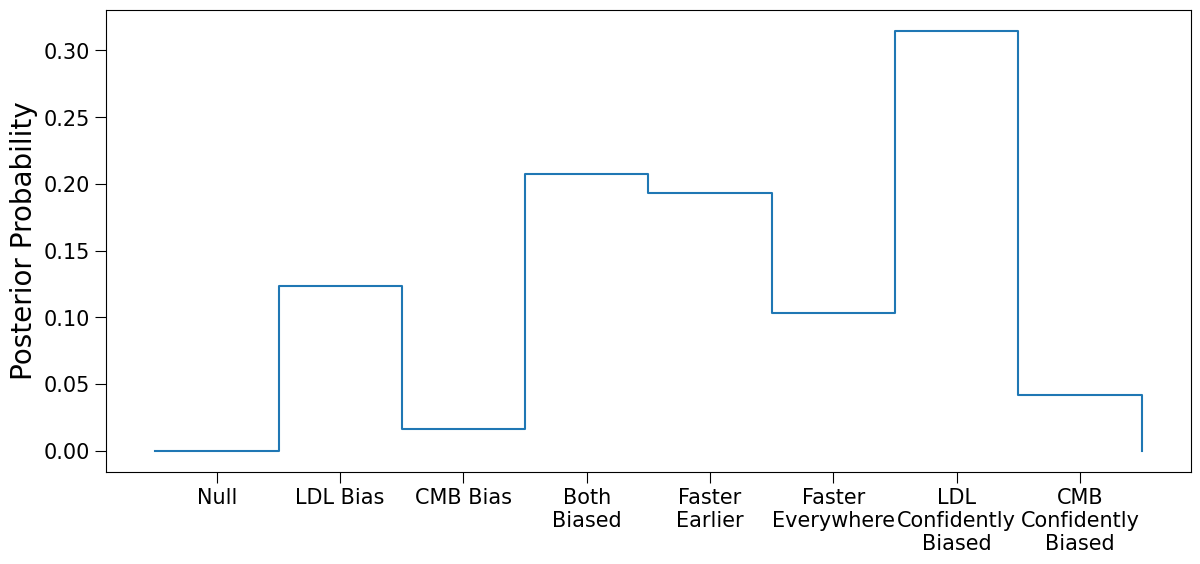

In [ ]:
# Load data
file_path = 'C:/Users/tjhug/Downloads/Dissertation Python Work-20250531T131215Z-1-001/Dissertation Python Work/H0 measurements.xlsx'
my_data = pd.read_excel(file_path, sheet_name='Independent points', nrows=16)
hubble_data = my_data.iloc[:, 6].to_numpy()
noise_column = my_data.iloc[:,12]
noise_width = noise_column.to_numpy()
category_column = my_data.iloc[:, 16].to_numpy()

# Initialise bias_mean and bias_cov
num_scenarios = 8
num_indices = 16
bias_mean = [np.full(num_indices, 0.0) for i in range(8)]
bias_cov = [np.zeros((num_indices, num_indices)) for i in range(8)]


# Group indices dynamically
category_groups = {'CMB': [], 'BAO': [], 'LDL': [], 'Local One Step': [],'Distant One Step': []}
for idx, category in enumerate(category_column):
    if category in category_groups:
        category_groups[category].append(idx)



scenario_configs = {
    1: {'CMB': 0, 'BAO': 0, 'LDL': 0, 'Local One Step': 0, 'Distant One Step':0, 'cov_CMB': 0, 'cov_BAO': 0, 'cov_LDL': 0, 'cov_Local One Step': 0, 'cov_Distant One Step': 0},
    2: {'CMB': 0, 'BAO': 0, 'LDL': 4, 'Local One Step': 0, 'Distant One Step':0, 'cov_CMB': 1, 'cov_BAO': noise_width[category_groups['BAO']], 'cov_LDL': 9, 'cov_Local One Step': noise_width[category_groups['Local One Step']], 'cov_Distant One Step': noise_width[category_groups['Distant One Step']]},
    3: {'CMB': -4, 'BAO': 0, 'LDL': 0, 'Local One Step': 0, 'Distant One Step':0, 'cov_CMB': 9, 'cov_BAO': noise_width[category_groups['BAO']], 'cov_LDL': 1, 'cov_Local One Step': noise_width[category_groups['Local One Step']],'cov_Distant One Step': noise_width[category_groups['Distant One Step']]},
    4: {'CMB': -2.5, 'BAO': 0, 'LDL': 2.5, 'Local One Step': 0, 'Distant One Step':0, 'cov_CMB': 2.25, 'cov_BAO': noise_width[category_groups['BAO']], 'cov_LDL': 2.25, 'cov_Local One Step': noise_width[category_groups['Local One Step']],'cov_Distant One Step': noise_width[category_groups['Distant One Step']]},
    5: {'CMB': -4.5, 'BAO': -3, 'LDL': 0, 'Local One Step': 0, 'Distant One Step':-1.5, 'cov_CMB': 2.25, 'cov_BAO': 2.25, 'cov_LDL': noise_width[category_groups['LDL']], 'cov_Local One Step': noise_width[category_groups['Local One Step']],'cov_Distant One Step': 2.25},
    6: {'CMB': -1.5, 'BAO': -1.5, 'LDL': 0, 'Local One Step': 0, 'Distant One Step':-1.5, 'cov_CMB': 2.25, 'cov_BAO': 2.25, 'cov_LDL': noise_width[category_groups['LDL']], 'cov_Local One Step': noise_width[category_groups['Local One Step']],'cov_Distant One Step': 2.25},
    7: {'CMB': 0, 'BAO': 0, 'LDL': 4, 'Local One Step': 0, 'Distant One Step':0, 'cov_CMB': 1, 'cov_BAO': noise_width[category_groups['BAO']], 'cov_LDL': 2.25, 'cov_Local One Step': noise_width[category_groups['Local One Step']], 'cov_Distant One Step': noise_width[category_groups['Distant One Step']]},
    8: {'CMB': -4, 'BAO': 0, 'LDL': 0, 'Local One Step': 0, 'Distant One Step':0, 'cov_CMB': 2.25, 'cov_BAO': noise_width[category_groups['BAO']], 'cov_LDL': 1, 'cov_Local One Step': noise_width[category_groups['Local One Step']],'cov_Distant One Step': noise_width[category_groups['Distant One Step']]},
}


random_indices = list(range(16))


def apply_bias_configurations(scenario_index, config, groups, random_indices):
    """
    Apply bias configurations with block-diagonal covariance:
    - For scenarios 1–3: covariance remains diagonal (independent).
    - For scenarios 4–6: covariance is block-diagonal, with perfect
      intra-group correlation (sqrt(var_i * var_j)).
    """
    scenario_index -= 1  # Adjust to zero-based indexing

    # Initialise temporary mean and covariance aligned to random indices
    temp_bias_mean = np.zeros(len(random_indices))
    temp_bias_cov = np.zeros((len(random_indices), len(random_indices)))

    for group_name, indices in groups.items():
        if group_name in config:
            # Assign group bias means
            bias_value = config[group_name]
            for original_idx in indices:
                if original_idx in random_indices:
                    reordered_idx = random_indices.index(original_idx)
                    temp_bias_mean[reordered_idx] = bias_value

            # Retrieve covariance specification for this group
            cov_value = config[f'cov_{group_name}']

            # Identify which indices from this group are sampled
            reordered_group_indices = [(i, random_indices.index(idx))
                                       for i, idx in enumerate(indices) if idx in random_indices]

            # Case: scenarios 1–3 (independent noise structure)
            if scenario_index <= 3 or scenario_index >= 6:
                for i1, row_idx in reordered_group_indices:
                    if np.isscalar(cov_value):
                        temp_bias_cov[row_idx, row_idx] = cov_value
                    else:
                        temp_bias_cov[row_idx, row_idx] = cov_value[i1]

            # Case: scenarios 4–6 (block diagonal with perfect correlation)
            else:
                for i1, row_idx in reordered_group_indices:
                    for i2, col_idx in reordered_group_indices:
                        if np.isscalar(cov_value):
                            var_i = var_j = cov_value
                        else:
                            var_i = cov_value[i1]
                            var_j = cov_value[i2]

                        if row_idx == col_idx:
                            temp_bias_cov[row_idx, col_idx] = var_i
                        else:
                            temp_bias_cov[row_idx, col_idx] = np.sqrt(var_i * var_j)

    # Save the reordered bias mean and covariance for the current scenario
    bias_mean[scenario_index] = temp_bias_mean
    bias_cov[scenario_index] = temp_bias_cov

# Apply configurations with reordering
for scenario_index, config in scenario_configs.items():
    apply_bias_configurations(scenario_index, config, category_groups, random_indices)

sampled_hubble_data = hubble_data[random_indices]
sampled_noise_data = noise_width[random_indices]
noise_cov = np.diag(np.full(num_indices, sampled_noise_data))

jkd = jk_data(meas_dat=sampled_hubble_data, noise_cov=noise_cov, simulate=False, num_draw=1, num_dat=num_indices)

tmp = tm_prior(func=uniform.pdf,
               bounds=[60, 80],
               params={"loc": 60, "scale": 20},
               name="Uniform") 

jkh = jk_hyp(jkd, 
               bias_mean=bias_mean, 
               bias_cov=bias_cov, 
               tmp=tmp, 
               hyp_prior=None, 
               mode="manual")

# Calculate non-anlytic posterior
jkc_num = jk_calc(jkh, analytic=False) 
print(jkc_num.post)


# Make a plot of the posteriors for each bias configuration
fontsize=20
tickfontsize=15
ticksize=8
plt.figure(figsize=(14, 6))
post_plot = np.append(jkc_num.post, 0)
plt.step(np.arange(-0.5, 8.5), post_plot, where='post') 
plt.ylabel("Posterior Probability", fontsize=fontsize)
plt.xticks(np.arange(8), labels=['Null', 'LDL Bias', 'CMB Bias', 'Both\nBiased', 'Faster\nEarlier', 'Faster\nEverywhere','LDL\nConfidently\nBiased','CMB\nConfidently\nBiased'], fontsize=10)
plt.tick_params(labelsize=tickfontsize, size=ticksize)
plt.show()


## Violin Plot of Posterior Distributions

Load posterior distributions from a saved pickle file.
Visualise the posterior distributions for each hypothesis using violin plots.
Overlay the full dataset posterior
This relates to Figure 6 in the paper.

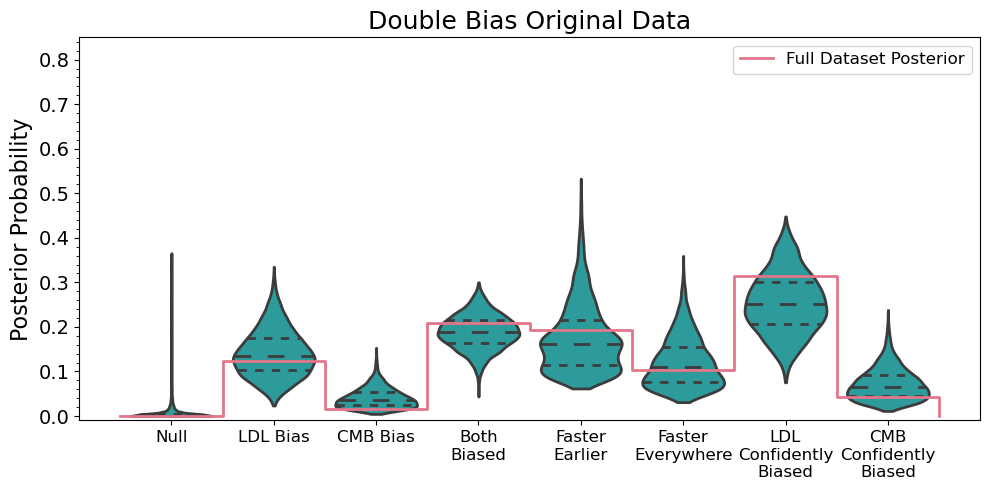

In [44]:
# Load the saved posteriors from pickle
output_file = "all_posteriors_double.pkl"
with open(output_file, "rb") as f:
    all_posteriors = pickle.load(f)


# Extract posterior values (assuming stored as tuples with other metadata)
posterior_array = np.array([entry[0] for entry in all_posteriors])

# Flatten array if it has more than 2 dimensions (samples x hypotheses)
if posterior_array.ndim > 2:
    posterior_array = posterior_array.reshape(posterior_array.shape[0], -1)

# Create a violin plot for each hypothesis
plt.figure(figsize=(10, 5))
sns.violinplot(
    data=posterior_array,
    inner="quart",        # Show quartiles inside the violin
    color='#1bacae',      # Color of the violins
    linewidth=2,          # Width of the violin edges
    cut=0,                # Avoid extending beyond extreme data points
    scale='width'         # Scale each violin to the same width
)

# Define hypothesis labels
labels=['Null', 'LDL Bias', 'CMB Bias', 'Both\nBiased', 'Faster\nEarlier', 'Faster\nEverywhere','LDL\nConfidently\nBiased','CMB\nConfidently\nBiased']

# Set axis labels and title
plt.xticks(np.arange(len(labels)), labels, size=12)
plt.yticks(size=14)
plt.title("Double Bias Original Data", size=18)
plt.ylabel("Posterior Probability", size=16)
plt.ylim(-0.01, 0.85)

# Overlay the full dataset posterior
post_plot = np.append(jkc_num.post, 0)  
plt.step(np.arange(-0.5, 8.5), post_plot, where='post', color='#e37789', linewidth=2, label="Full Dataset Posterior")

# Add legend
plt.legend(fontsize=12, loc="upper right")

# Minor tick adjustments
plt.gca().tick_params(axis='x', which='minor', bottom=False)
plt.minorticks_on()
plt.tight_layout()
plt.show()




# Posterior Search and Frequency Plot
This section loads posterior results from file, searches for cases where a hypothesis exceeds
given posterior thresholds, and visualises the frequency of selected data points.

In [45]:
def search_posteriors(hypothesis_index, threshold):
    """
    Search the posterior results for cases where the posterior of a given hypothesis
    exceeds a user-specified threshold.

    Parameters
    ----------
    hypothesis_index : int
        Index of the hypothesis to check.
    threshold : float
        Threshold value above which the posterior must fall.

    Returns
    -------
    list of list of int
        A list of index lists corresponding to data points contributing to matches.
    """
    with open(output_file, "rb") as f:
        data = pickle.load(f)
    
    # Filter by posterior threshold
    filtered_results = [(post, indices) for post, indices in data if post[hypothesis_index] > threshold]
    print(f"Found {len(filtered_results)} cases where hypothesis {hypothesis_index} "
          f"has a posterior > {threshold}.\n")

    # Extract just the indices for matching cases
    selected_indices = [indices for _, indices in filtered_results]
    return selected_indices



## Example Usage
 We will look at the **LDL Confidently Biased** hypothesis and check two thresholds: 0.4 and 0.6.

In [46]:
hypothesis_index = 6
threshold = 0.3  # threshold


# Get results at both thresholds
matching_results_0_3 = search_posteriors(hypothesis_index, threshold)


# Flatten nested lists into one list of indices
all_selected_indices_0_3 = [idx for sublist in matching_results_0_3 for idx in sublist]

# Count how often each index appears
unique_0_3, counts_0_3 = np.unique(all_selected_indices_0_3, return_counts=True)



Found 1111 cases where hypothesis 6 has a posterior > 0.3.



## Frequency Plot
Plot the frequency of data points for both thresholds:
This relates to Figure 7 in the paper. 

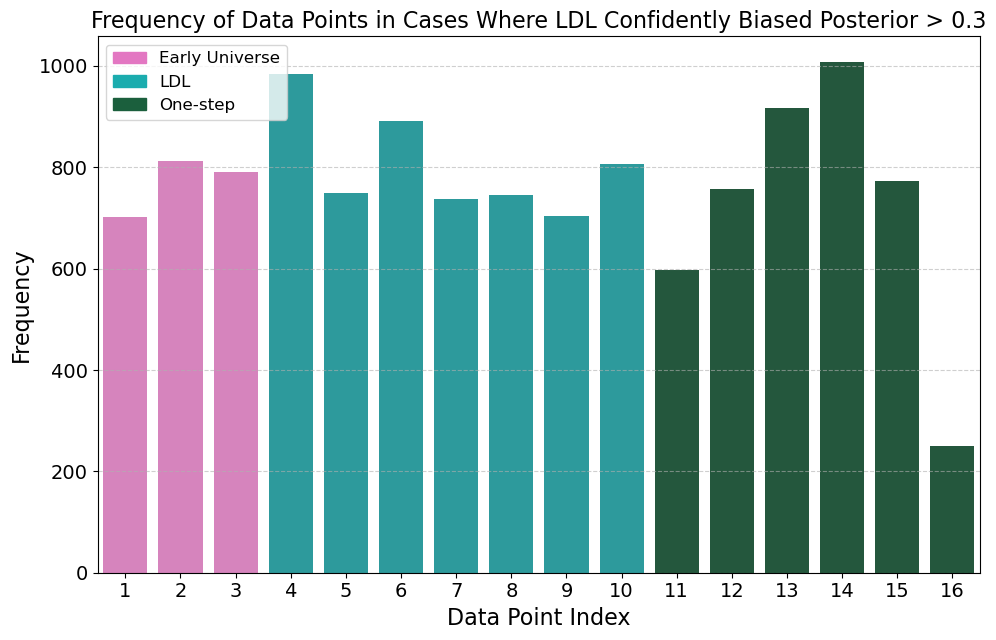

In [48]:
# Group coloring scheme: early universe, LDL, one-step
colors_map = ['#e377c2']*3 + ['#1bacae']*7 + ['#1b5f3d']*6

def get_colors_for_bars(x_vals):
    """Return color assignments for each bar index."""
    return [colors_map[x] for x in x_vals]

plt.figure(figsize=(10, 6.5))

# Bars for threshold > 0.4
sns.barplot(x=unique_0_3, y=counts_0_3, palette=get_colors_for_bars(unique_0_3))

# Axis labels and ticks
labels = np.arange(1, 17)
plt.xticks(ticks=np.arange(len(labels)), labels=labels, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Data Point Index", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

# Legend patches
early_patch = mpatches.Patch(color='#e377c2', label='Early Universe')
ldl_patch = mpatches.Patch(color='#1bacae', label='LDL')
one_step_patch = mpatches.Patch(color='#1b5f3d', label='One-step')


plt.legend(handles=[early_patch, ldl_patch, one_step_patch],
           loc='upper left', fontsize=12)

# Title, grid, save, and show
plt.title(f"Frequency of Data Points in Cases Where LDL Confidently Biased Posterior > {threshold}", fontsize=16)
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()